In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/asl_dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2515 files belonging to 36 classes.


In [8]:
class_names = dataset.class_names
class_names

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[13 14  1 32 28 30  0 11  7 35  2  8 20  1 24  5 29 26 19 26 22 33 11 15
 31 31 17  7 19 22  3 12]


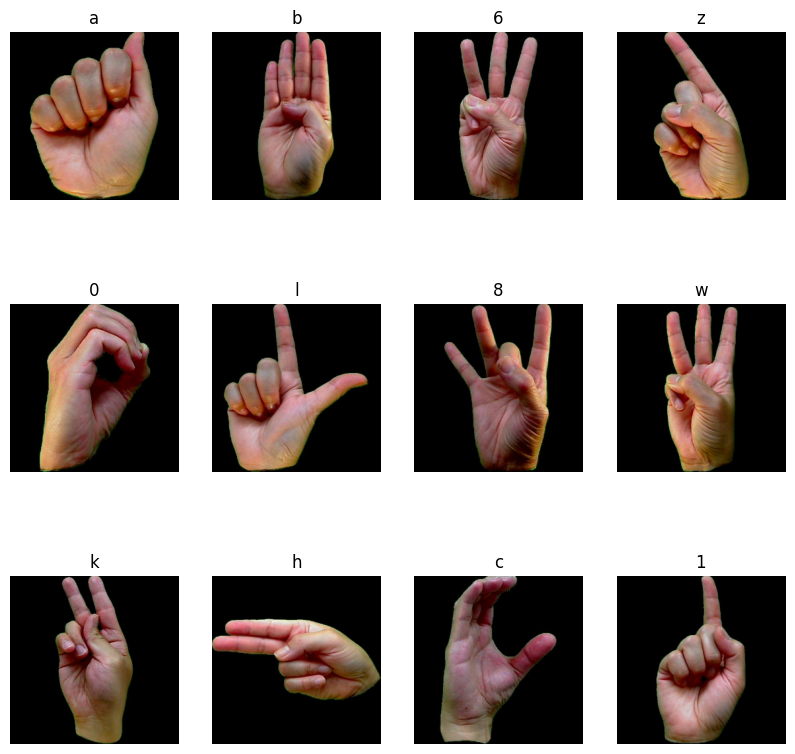

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
len(dataset)

79

In [12]:
train_size = 0.8
len(dataset)*train_size

63.2

In [13]:
train_ds = dataset.take(63)
len(train_ds)

63

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

25

In [15]:
val_size=0.1
len(dataset)*val_size

7.9

In [16]:
val_ds = test_ds.take(8)
len(val_ds)

8

In [17]:
test_ds = test_ds.skip(8)
len(test_ds)

17

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

63

In [21]:
len(val_ds)

7

In [22]:
len(test_ds)

9

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Resize images
    tf.keras.layers.Rescaling(1.0 / 255),             # Rescale pixel values
])

In [25]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [26]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [27]:
len(class_names)

36

In [28]:
#input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 36

model = models.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Define input shape here
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])



model.build()  # Batch size as `None`

In [29]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │           2,340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,745,124 (14.29 MB)

 Trainable params: 3,745,124 (14.29 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 753s 527ms/step - accuracy: 0.0564 - loss: 3.5484 - val_accuracy: 0.1786 - val_loss: 2.9229
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 73s 364ms/step - accuracy: 0.1882 - loss: 2.8401 - val_accuracy: 0.2768 - val_loss: 2.3095
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 339ms/step - accuracy: 0.3217 - loss: 2.1693 - val_accuracy: 0.4821 - val_loss: 1.6509
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 353ms/step - accuracy: 0.4604 - loss: 1.7066 - val_accuracy: 0.5045 - val_loss: 1.4658
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step - accuracy: 0.5577 - loss: 1.3576 - val_accuracy: 0.5625 - val_loss: 1.2311
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - accuracy: 0.5858 - loss: 1.2116 - val_accuracy: 0.6562 - val_loss: 0.8924
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.6518 - loss: 1.0397 - val_accuracy: 0.7277 - val_loss: 0.7906
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 360ms/step - accuracy: 0.7027 - loss: 0.8784 - val_acc

In [32]:
scores = model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9719 - loss: 0.1094


In [33]:
scores = model.evaluate(train_ds)

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - accuracy: 0.9413 - loss: 0.1550


In [34]:
scores

[0.16011309623718262, 0.9355158805847168]

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 63}

In [37]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [38]:
type(history.history['loss'])

list

In [39]:
len(history.history['loss'])

50

In [40]:
history.history['loss'][:5] # show loss for first 5 epochs

[3.4212584495544434,
 2.6780152320861816,
 2.02738356590271,
 1.593955636024475,
 1.3160929679870605]

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

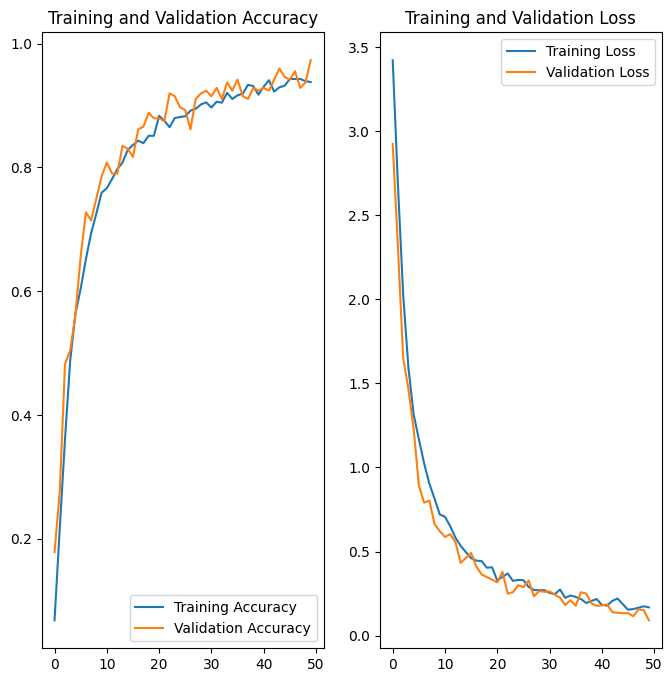

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
predicted label: s


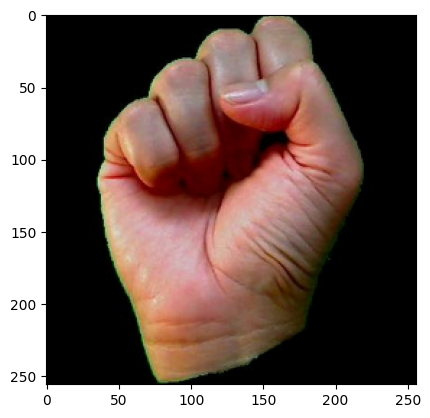

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


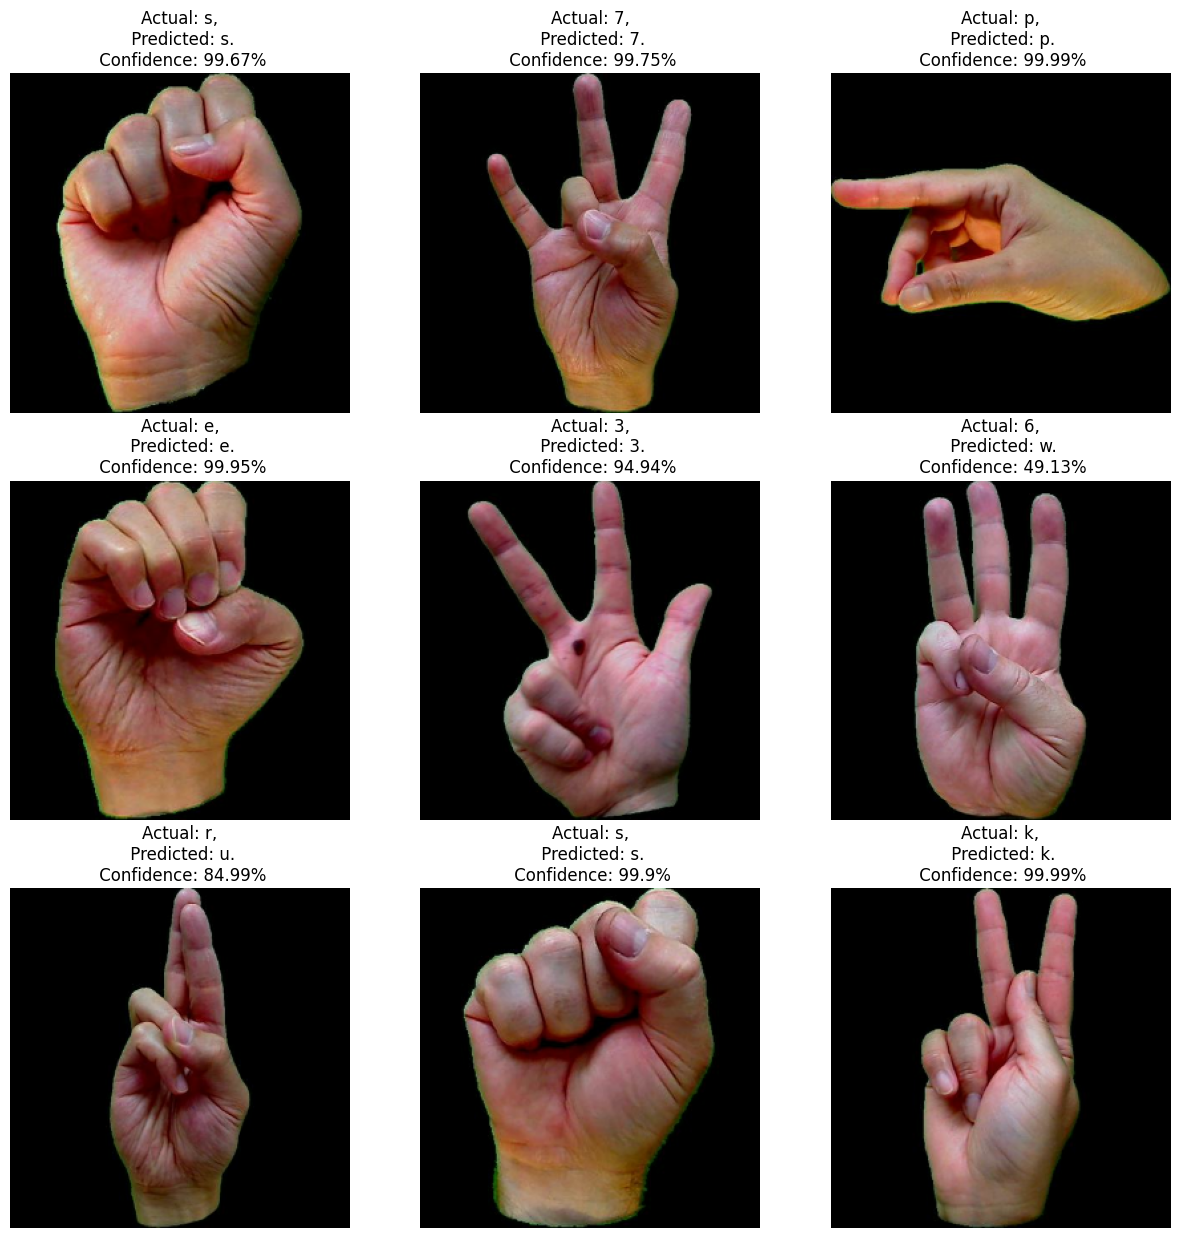

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [57]:
model.save("/content/drive/MyDrive/App/ASL_Model.h5")

In [58]:

# Specify the path to your .h5 model
h5_model_path = "/content/drive/MyDrive/App/ASL_Model.h5"

# Load the .h5 model
model = tf.keras.models.load_model(h5_model_path)
print("Model loaded successfully.")

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = "/content/drive/MyDrive/App/ASL_TFLITE.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {tflite_model_path}")


Model loaded successfully.
Saved artifact at '/tmp/tmp6oskky6h'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  134130992960384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130992969536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130992963376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130992963904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130992909824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130992911760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130992917568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130957064272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130957065680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130957062864: TensorSpec(shape=(), dtype=tf.resource